In [1]:
%load_ext autoreload
%reload_ext autoreload

%autoreload 2
%matplotlib inline
import tensorflow
from tensorflow.compat.v1.keras.backend import get_session
tensorflow.compat.v1.disable_v2_behavior()
import math
import kerasAC 
from scipy.special import softmax,expit
from kerasAC.interpret.deepshap import * 
from kerasAC.interpret.profile_shap import * 
from kerasAC.vis import * 
from kerasAC.helpers.transform_bpnet_io import * 
from kerasAC.util import * 
import pandas as pd

## for plotting 

import matplotlib 
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"]=10,5
plt.rcParams['axes.xmargin'] = 0

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 10}

matplotlib.rc('font', **font)

import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"

Instructions for updating:
non-resource variables are not supported in the long term


Using TensorFlow backend.
/mnt/lab_data3/anusri/kerasAC/kerasAC/vis/plot_letters.py:172: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  min_coords = np.vstack(data.min(0) for data in polygons_data).min(0)
/mnt/lab_data3/anusri/kerasAC/kerasAC/vis/plot_letters.py:173: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  max_coords = np.vstack(data.max(0) for data in polygons_data).max(0)


In [2]:
import pysam 
ref=pysam.FastaFile("/mnt/data/GRCh38_no_alt_analysis_set_GCA_000001405.15.fasta")

In [3]:
#load the model! 
from tensorflow.keras.models import load_model, model_from_json
from tensorflow.keras.utils import get_custom_objects
from kerasAC.metrics import * 
from kerasAC.custom_losses import * 
from keras_genomics.layers.convolutional import RevCompConv1D
import tensorflow_probability as tfp

custom_objects={"recall":recall,
                "sensitivity":recall,
                "specificity":specificity,
                "fpr":fpr,
                "fnr":fnr,
                "precision":precision,
                "f1":f1,
                "ambig_binary_crossentropy":ambig_binary_crossentropy,
                "ambig_mean_absolute_error":ambig_mean_absolute_error,
                "ambig_mean_squared_error":ambig_mean_squared_error,
                "MultichannelMultinomialNLL":MultichannelMultinomialNLL,
                "MultichannelMultinomialMSE":MultichannelMultinomialMSE,                
                "RevCompConv1D": RevCompConv1D}
get_custom_objects().update(custom_objects)
#load dnase model from architecture and trained weights 
#import json 
#dnase_model=model_from_json(open("gm12878.dnase.with.bpnet.tobias.bias.0.arch",'r').read())
#dnase_model.load_weights("gm12878.dnase.with.bpnet.tobias.bias.0.weights")
#histone_model=load_model("patience_6_5K_out_12_gm12878.h3k27ac.seed.2345.cs.25.filters.300.naive.range.4.6.to.11.5.0.hdf5")
#dnase_model=load_model("/srv/scratch/anusri/chrombpnet_paper/results/chrombpnet/ATAC/GM12878/4_4_shifted_ATAC_09.06.2021_bias_filters_500/final_model_step3/unplug/model.0.hdf5")
dnase_model=load_model("/srv/scratch/anusri/chrombpnet_paper/results/chrombpnet/DNASE/GM12878/4_1_shifted_DNASE_10.04.2021_bias_filters_128/final_model_step3/unplug/model.0.hdf5")

In [4]:
import shap
from deeplift.dinuc_shuffle import dinuc_shuffle

def combine_mult_and_diffref(mult, orig_inp, bg_data):
    to_return = []
    for l in [0]:
        projected_hypothetical_contribs = np.zeros_like(bg_data[l]).astype("float")
        assert len(orig_inp[l].shape)==2
        for i in range(orig_inp[l].shape[-1]):
            hypothetical_input = np.zeros_like(orig_inp[l]).astype("float")
            hypothetical_input[:,i] = 1.0
            hypothetical_difference_from_reference = (hypothetical_input[None,:,:]-bg_data[l])
            hypothetical_contribs = hypothetical_difference_from_reference*mult[l]
            projected_hypothetical_contribs[:,:,i] = np.sum(hypothetical_contribs,axis=-1) 
        to_return.append(np.mean(projected_hypothetical_contribs,axis=0))
    to_return.append(np.zeros_like(orig_inp[1]))
    return to_return

def shuffle_several_times(s):
    numshuffles=20
    return [np.array([dinuc_shuffle(s[0]) for i in range(numshuffles)]),
            np.array([s[1] for i in range(numshuffles)])]


In [5]:
#Histone chip 
#histone_wrapper=([histone_model.input[0],histone_model.input[2]],histone_model.outputs[1][:,0:1])
#histone_count_explainer=shap.DeepExplainer(histone_wrapper,
#                                     data=create_background_counts_chip,
#                                     combine_mult_and_diffref=combine_mult_and_diffref_chip)
#histone_prof_explainer=create_explainer(histone_model,ischip=True,task_index=0)



In [6]:
#DNASE
dnase_wrapper=(dnase_model.input,dnase_model.outputs[1][:,0:1])
dnase_count_explainer=shap.DeepExplainer(dnase_wrapper,
                                        data=create_background_atac,
                                        combine_mult_and_diffref=combine_mult_and_diffref_atac)
dnase_prof_explainer=create_explainer(dnase_model,ischip=False,task_index=0)


In [7]:
## source signal tracks 
import pyBigWig
#DNASE 
#dnase_bw=pyBigWig.open("/srv/scratch/anusri/chrombpnet_paper/results/chrombpnet/ATAC/GM12878/data/shifted.sorted.bam.bpnet.unstranded.bw",'r')
dnase_bw=pyBigWig.open("/srv/scratch/anusri/chrombpnet_paper/results/chrombpnet/DNASE/GM12878/data/shifted.sorted.bam.bpnet.unstranded.bw",'r')

#SPI1 TF 
#tf_pos=pyBigWig.open("/srv/scratch/annashch/chrombpnet/gm12878_tf_dnase_histone/spi1_tf/pos_strand.bw")
#tf_neg=pyBigWig.open("/srv/scratch/annashch/chrombpnet/gm12878_tf_dnase_histone/spi1_tf/neg_strand.bw")
#tf_control_pos=pyBigWig.open("/srv/scratch/annashch/chrombpnet/gm12878_tf_dnase_histone/spi1_tf/control_neg_strand.bw")
#tf_control_neg=pyBigWig.open("/srv/scratch/annashch/chrombpnet/gm12878_tf_dnase_histone/spi1_tf/control_pos_strand.bw")

#H3K27AC 
#chip_pos=pyBigWig.open("/srv/scratch/annashch/chrombpnet/gm12878_tf_dnase_histone/h3k27ac/K562.merged.ENCSR000APK.gz.bam.bpnet.plus.bw")
#chip_neg=pyBigWig.open("/srv/scratch/annashch/chrombpnet/gm12878_tf_dnase_histone/h3k27ac/K562.merged.ENCSR000APK.gz.bam.bpnet.minus.bw")
#chip_control_pos=pyBigWig.open("/srv/scratch/annashch/chrombpnet/gm12878_tf_dnase_histone/h3k27ac/K562.merged.control.ENCSR000AKY.gz.bam.bpnet.plus.bw")
#chip_control_neg=pyBigWig.open("/srv/scratch/annashch/chrombpnet/gm12878_tf_dnase_histone/h3k27ac/K562.merged.control.ENCSR000AKY.gz.bam.bpnet.minus.bw")


In [8]:
#USE HG38 
#regions=pd.read_csv("bQTL.for.ism.csv",header=0,sep='\t')
regions=pd.read_csv("bQTL.intersection.csv",header=0,sep='\t')
regions

,Chrom,hg19pos0,hg38pos0,Major,Minor,Group,Rsid
0,chr22,44116809,43720929,C,G,StrongbQTL,rs5764238


In [9]:
def get_preds(model,inputs):
    preds=model.predict(inputs)
    prof=np.squeeze(preds[0])
    probs=softmax(prof,axis=0)
    count=np.squeeze(preds[1])  
    print(count)
    print(np.exp(count))
    count_track=probs*np.exp(count) 
    return prof,count,probs,count_track

In [10]:
def analyze_dnase(ref,
            chrom,
            summit,
            ref_allele,
            alt_allele,
            rsid,
            model,
            count_explainer,
            prof_explainer,
            flank=1057,
            output_bp=1000,
            bigwig_unstranded=None):
    #get the reference and alternate one-hot-encoded sequences 
    seq=ref.fetch(chrom,summit-flank,summit+flank)
    
    ref_seq=seq[0:flank]+ref_allele+seq[flank+1::]
    assert len(ref_seq)==2*flank
    ref_onehot=one_hot_encode([ref_seq])
    
    alt_seq=seq[0:flank]+alt_allele+seq[flank+1::]
    assert len(alt_seq)==2*flank
    alt_onehot=one_hot_encode([alt_seq])
    
    #get the bigwig labels 
    labels_unstranded=np.nan_to_num(bigwig_unstranded.values(chrom,summit-flank,summit+flank))
    model_input_ref=ref_onehot
    model_input_alt=alt_onehot
    #get predictions for reference & alternate allele 
    prof_ref,count_ref,probs_ref,count_track_ref=get_preds(model,model_input_ref)
    prof_alt,count_alt,probs_alt,count_track_alt=get_preds(model,model_input_alt)

        
    #get the log odds blast radius track 
    blast_radius_track=np.log(probs_ref)-np.log(probs_alt)
    blast_radius_count_track=np.log2(count_track_ref)-np.log2(count_track_alt)
    #get deepSHAP scores for ref & alt alleles     
    profile_explanations_ref=prof_explainer(ref_onehot,None)*ref_onehot
    count_explanations_ref=np.squeeze(count_explainer.shap_values(ref_onehot)[0])*ref_onehot 

    profile_explanations_alt=prof_explainer(alt_onehot,None)*alt_onehot
    count_explanations_alt=np.squeeze(count_explainer.shap_values(alt_onehot)[0])*alt_onehot  
    
    #look at dimensions of size 1000 
    offset=int((2*flank-output_bp)/2)
    labels_unstranded=labels_unstranded[offset:offset+output_bp]
    profile_explanations_ref=np.squeeze(profile_explanations_ref)[offset:offset+output_bp,:]
    profile_explanations_alt=np.squeeze(profile_explanations_alt)[offset:offset+output_bp,:]
    count_explanations_ref=np.squeeze(count_explanations_ref)[offset:offset+output_bp,:]
    count_explanations_alt=np.squeeze(count_explanations_alt)[offset:offset+output_bp,:]
    
    
    return labels_unstranded,count_track_ref,count_track_alt,blast_radius_track, blast_radius_count_track, profile_explanations_ref,count_explanations_ref, profile_explanations_alt, count_explanations_alt

In [11]:
def rolling_window(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

def smooth_profiles(profiles, smoothing_window):
    assert len(profiles.shape)==3
    leftpadlen = int((smoothing_window-1)/2)
    rightpadlen =\
        (smoothing_window-1)-int((smoothing_window-1)/2)
    padded_profiles = np.pad(
        array=profiles,
        pad_width=((0,0),(leftpadlen, rightpadlen), (0,0)),
        mode='edge')
    smoothed_profiles = np.mean(rolling_window(
                        a=padded_profiles.transpose(0,2,1),
                        window=smoothing_window), axis=-1).transpose((0,2,1))
    return smoothed_profiles

def get_preds_tf(model,inputs):
    preds=model.predict(inputs)
    prof=np.squeeze(preds[1])
    probs=softmax(prof,axis=0)
    count=np.squeeze(preds[0])  
    count_track=probs*np.exp(count)
    return prof,count,probs,count_track



In [12]:
from scipy.special import softmax 
def make_plot(dnase_labels_unstranded,
              dnase_count_track_ref,
              dnase_count_track_alt,
              dnase_blast_radius_track,
              dnase_blat_radius_counts_track,
              dnase_profile_explanations_ref, 
              dnase_count_explanations_ref, 
              dnase_profile_explanations_alt, 
              dnase_count_explanations_alt,
              title,
              xmin=0,
              xmax=1000): 
    plt.rcParams["figure.figsize"]=45,35
    f,axes=plt.subplots(8, 1,gridspec_kw={
                           'width_ratios': [1],
                           'height_ratios': [1, 2, 1,1, 1, 1, 1,1]})
    #labels count track 
    axes[0].plot(dnase_labels_unstranded)  
    axes[0].set_title("DNASE labels",fontsize=20)


    #ref vs alt preds 
    axes[1].plot(dnase_count_track_ref,linewidth=0.25,label='ref',color='b')
    axes[1].plot(dnase_count_track_alt,linewidth=0.25,label='alt',color='r')    
    axes[1].set_title("DNASE Predicted Count Track (Ref vs Alt)",fontsize=20)
    axes[1].legend()

    #log2 counts per base ref - log2 counts per base alt 
    axes[2].plot(dnase_blast_radius_counts_track)
    axes[2].set_title("DNASE Counts Blast Radius log2(base counts(ref))-log2(base counts(alt))",fontsize=20)

    
    # Blast radius 
    axes[3].plot(dnase_blast_radius_track)
    axes[3].set_title("DNASE Blast Radius log(prob(ref))-log(prob(alt))",fontsize=20)

    #DeepSHAP Profile Ref 
    axes[4]=plot_bases_on_ax(dnase_profile_explanations_ref[400:600],axes[4],show_ticks=False)

    
    #DeepSHAP Profile Alt 
    axes[5]=plot_bases_on_ax(dnase_profile_explanations_alt[400:600],axes[5],show_ticks=False)
    axes[5].set_title("DNASE Alt Prof SHAP",fontsize=20)
 
        
    #DeepSHAP Count Ref
    axes[6]=plot_bases_on_ax(dnase_count_explanations_ref[400:600],axes[6],show_ticks=False)
    axes[6].set_title("DNASE Ref Count SHAP",fontsize=20)

    #DeepSHAP Count Alt 
    axes[7]=plot_bases_on_ax(dnase_count_explanations_alt[400:600],axes[7],show_ticks=False)
    axes[7].set_title("DNASE Alt Count SHAP",fontsize=20)
  

    #set ylim for deepSHAP 
    dnase_profile_shap_min=min([np.min(dnase_profile_explanations_ref),
           np.min(dnase_profile_explanations_alt)])
    dnase_count_shap_min=min([np.min(dnase_count_explanations_ref),
           np.min(dnase_count_explanations_alt)])

    dnase_profile_shap_max=max([np.max(dnase_profile_explanations_ref),
           np.max(dnase_profile_explanations_alt)])
    dnase_count_shap_max=max([np.max(dnase_count_explanations_ref),
           np.max(dnase_count_explanations_alt)])
    
    axes[4].set_ylim(dnase_profile_shap_min,dnase_profile_shap_max)
    axes[5].set_ylim(dnase_profile_shap_min,dnase_profile_shap_max)
    axes[6].set_ylim(dnase_count_shap_min,dnase_count_shap_max)
    axes[7].set_ylim(dnase_count_shap_min,dnase_count_shap_max)


    plt.suptitle(title,fontsize=20)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(title.replace('/',':')+'.pdf',format='pdf',dpi=300)
    plt.show()
 

In [13]:
import pdb
for index,row in regions.iterrows(): 
    chrom=row['Chrom']
    summit=row['hg38pos0']
    ref_allele=row['Major']
    alt_allele=row['Minor']
    rsid=row['Rsid']
    print(index)
    
    #DNASE 
    dnase_labels_unstranded,dnase_count_track_ref,dnase_count_track_alt,dnase_blast_radius_track, dnase_blast_radius_counts_track,dnase_profile_explanations_ref, dnase_count_explanations_ref, dnase_profile_explanations_alt, dnase_count_explanations_alt=analyze_dnase(ref=ref,
            chrom=chrom,
            summit=summit,
            ref_allele=ref_allele,
            alt_allele=alt_allele,
            rsid=rsid,
            bigwig_unstranded=dnase_bw,
            model=dnase_model,
            count_explainer=dnase_count_explainer,
            prof_explainer=dnase_prof_explainer,
            flank=1057)
  
    make_plot(dnase_labels_unstranded,
              dnase_count_track_ref,
              dnase_count_track_alt,
              dnase_blast_radius_track,
              dnase_blast_radius_counts_track,
              dnase_profile_explanations_ref, 
              dnase_count_explanations_ref, 
              dnase_profile_explanations_alt, 
              dnase_count_explanations_alt,
              rsid+":"+chrom+":"+str(summit)+":ref="+ref_allele+":alt="+alt_allele)

0
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
3.8320441
46.15679
4.260966
70.8784


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


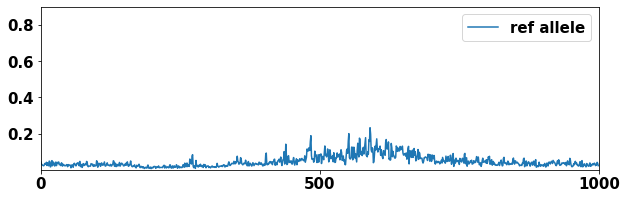

In [14]:
%matplotlib inline
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}

matplotlib.rc('font', **font)
plt.rcParams["figure.figsize"] = (10,3)

plt.figure()
plt.plot(dnase_count_track_ref, label="ref allele")
plt.ylim(0,0.9)
plt.yticks([0.2,0.4,0.6,0.8])
plt.xticks([0,500,1000])
plt.legend()

plt.show()



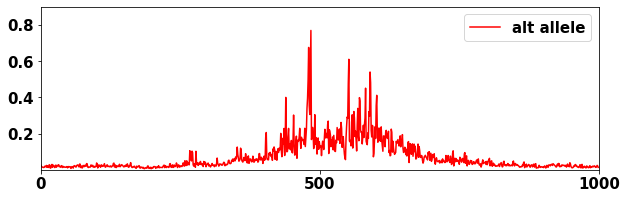

In [15]:
%matplotlib inline
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}

matplotlib.rc('font', **font)
plt.rcParams["figure.figsize"] = (10,3)


plt.figure()
plt.plot(dnase_count_track_alt, color="r", label="alt allele")
plt.ylim(0,0.9)
plt.yticks([0.2,0.4,0.6,0.8])
plt.xticks([0,500,1000])
plt.legend()

plt.show()

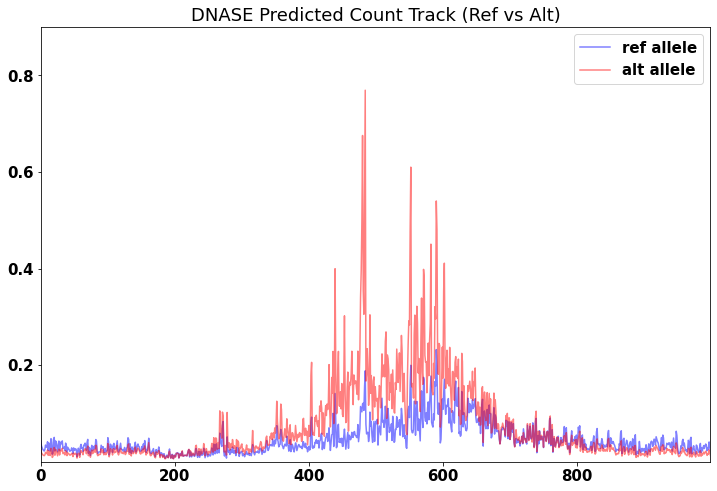

In [18]:
plt.rcParams["figure.figsize"] = (12,8)

plt.figure()
plt.plot(dnase_count_track_ref, color="b", label="ref allele", alpha=0.5)
plt.plot(dnase_count_track_alt, color="r", label="alt allele", alpha=0.5)
plt.ylim(0,0.9)
plt.yticks([0.2,0.4,0.6,0.8])
plt.xticks([0,200,400,600,800])
plt.title("DNASE Predicted Count Track (Ref vs Alt)")
plt.legend()

plt.show()

([<matplotlib.axis.YTick at 0x7f82e184c050>,
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

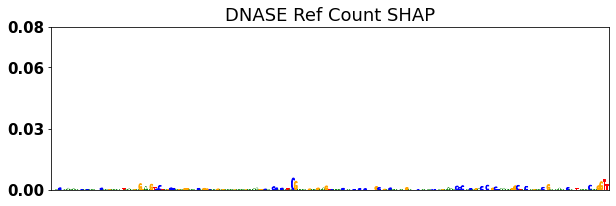

In [25]:
f,axes=plt.subplots(1, 1,sharey=False)
 
plt.rcParams["figure.figsize"] = (10,3)
plot_bases_on_ax(dnase_count_explanations_ref[400:600],axes,show_ticks=False)
#axes[0].set_title("DNASE Ref Prof SHAP",fontsize=20)
#plot_bases_on_ax(dnase_profile_explanations_alt[425:575],axes[1],show_ticks=False)
#axes[1].set_title("DNASE Ref  Prof SHAP",fontsize=20)
axes.set_ylim(0,0.08)
axes.set_title("DNASE Ref Count SHAP")
#axes[1].set_ylim(0,0.025)
plt.yticks([0.0,0.03, 0.06,0.08])
#f.subplots_adjust(wspace=0.1, hspace=0.2)

